In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import plotly.express as px
from nltk.corpus import stopwords
from collections import defaultdict
import re

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\m_shanmugavel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\m_shanmugavel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\m_shanmugavel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### The financial news dataset consists of 4840 sentences from English language financial news categorised by sentiment. The dataset was evaluated by 5 to 8 annotators who are experts in financial services. The datasets was then divided as following and offered as 4 different subsets. 
- Number of instances with >=50% annotator agreement
- Number of instances with >=66% annotator agreement
- Number of instances with >=75% annotator agreement
- Number of instances with 100% annotator agreement

In [98]:
# Dataframe with number of instances >=50% annotator agreement
df_50 = pd.read_csv('Sentences_50Agree.txt', delimiter='.@', encoding='ISO-8859-1', engine='python', header=None)

In [8]:
df_50

,0,1
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,negative
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
4843,Operating profit fell to EUR 35.4 mn from EUR ...,negative
4844,Net sales of the Paper segment decreased to EU...,negative


In [99]:
# Dataframe with number of instances >=66% annotator agreement
df_66 = pd.read_csv('Sentences_66Agree.txt', delimiter='.@', encoding='ISO-8859-1', engine='python', header=None)

In [10]:
df_66

,0,1
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,"For the last quarter of 2010 , Componenta 's n...",positive
...,...,...
4212,HELSINKI Thomson Financial - Shares in Cargote...,negative
4213,LONDON MarketWatch -- Share prices ended lower...,negative
4214,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
4215,Operating profit fell to EUR 35.4 mn from EUR ...,negative


In [100]:
# Dataframe with number of instances >=75% annotator agreement
df_75 = pd.read_csv('Sentences_75Agree.txt', delimiter='.@', encoding='ISO-8859-1', engine='python', header=None)

In [12]:
df_75

,0,1
0,"According to Gran , the company has no plans t...",neutral
1,With the new production plant the company woul...,positive
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,"In the third quarter of 2010 , net sales incre...",positive
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive
...,...,...
3448,Operating result for the 12-month period decre...,negative
3449,HELSINKI Thomson Financial - Shares in Cargote...,negative
3450,LONDON MarketWatch -- Share prices ended lower...,negative
3451,Operating profit fell to EUR 35.4 mn from EUR ...,negative


In [101]:
# Dataframe with 100% annotator agreement. Decided to use this dataframe to build the model
colnames=['text', 'sentiment'] 
df_all = pd.read_csv('Sentences_AllAgree.txt', delimiter='.@', encoding='ISO-8859-1', engine='python', names=colnames, header=None)

In [24]:
df_all

,text,sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive
...,...,...
2259,Operating result for the 12-month period decre...,negative
2260,HELSINKI Thomson Financial - Shares in Cargote...,negative
2261,LONDON MarketWatch -- Share prices ended lower...,negative
2262,Operating profit fell to EUR 35.4 mn from EUR ...,negative


In [51]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       2264 non-null   object
 1   sentiment  2264 non-null   object
dtypes: object(2)
memory usage: 35.5+ KB


In [71]:
df_all['sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [102]:
#No missing values
df_all.isnull().sum()

text         0
sentiment    0
dtype: int64

In [74]:
df_all['sentiment'].value_counts()

sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

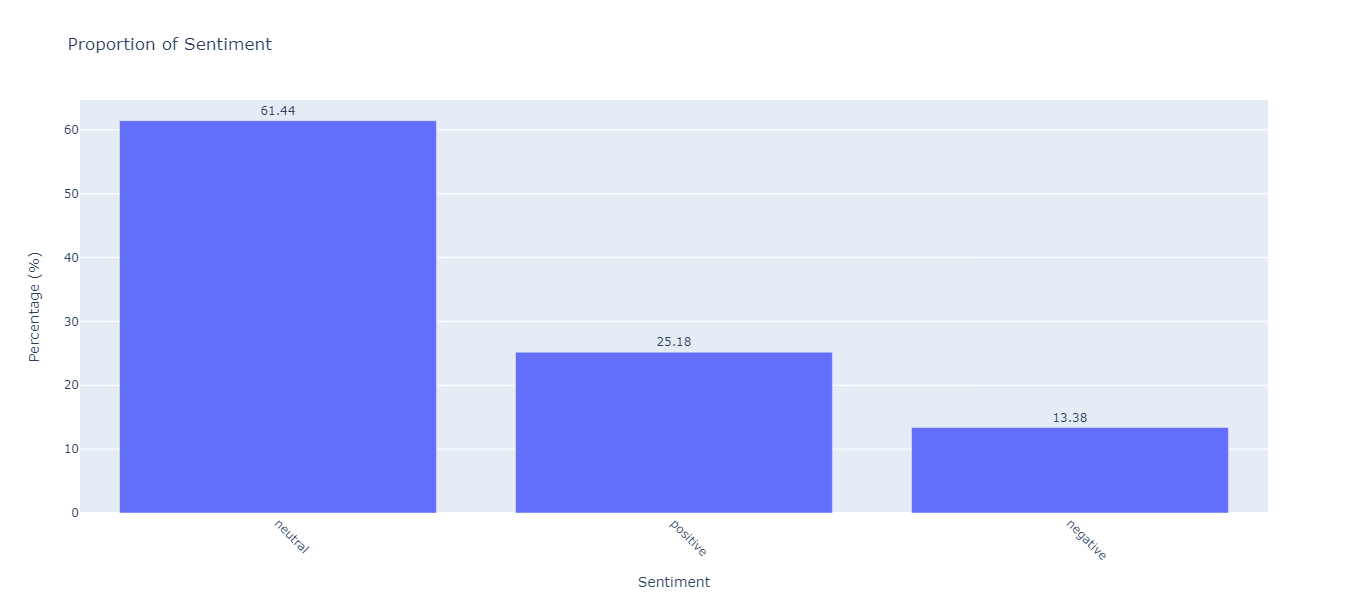

In [103]:
#Proportion of sentiments 
y_counts = df_all['sentiment'].value_counts(normalize=True) * 100

fig = px.bar(x=y_counts.index, y=y_counts.values,
             labels={'x': 'Sentiment', 'y': 'Percentage (%)'},
             title='Proportion of Sentiment',
             text=y_counts.values)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(xaxis=dict(tickangle=45), height=600, width=600)
fig.show()


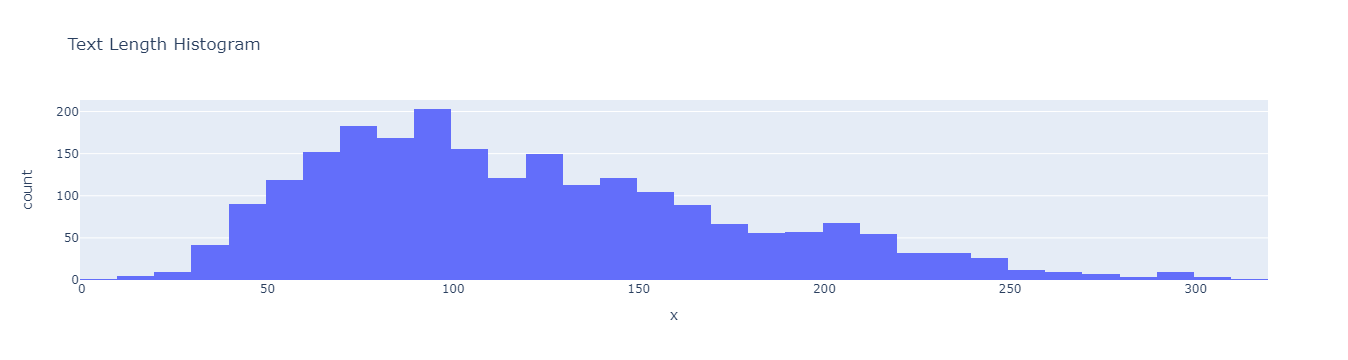

In [105]:
#length of each news.There were more news with length around 90 to 99 characters and in general between 40 and 250 characters
fig = px.histogram(df_all, x=df_all['text'].str.len(), title="Text Length Histogram")
fig.show()

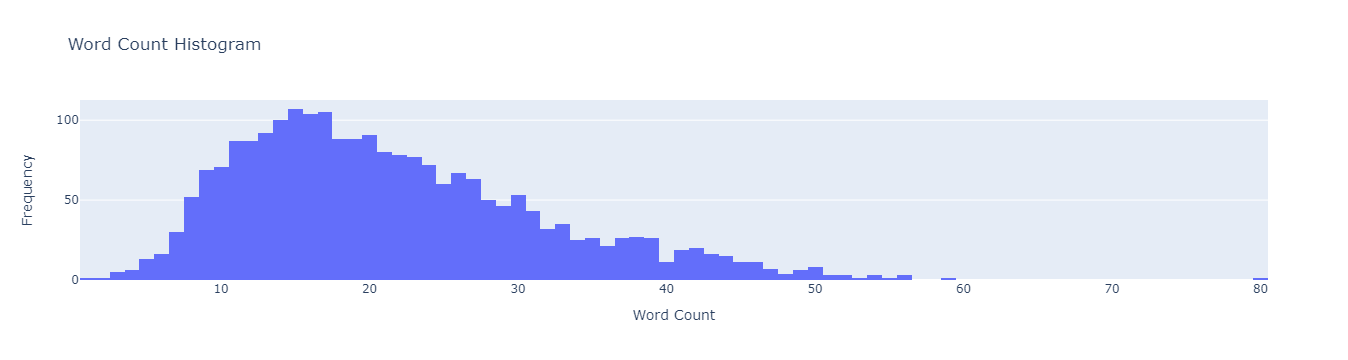

In [107]:
#follolwing histogram shows the frequency of words in the news.The number of words seems to vary from 5 to 50
word_counts = df_all['text'].str.split().map(lambda x: len(x))

fig = px.histogram(x=word_counts, title="Word Count Histogram")
fig.update_layout(xaxis_title="Word Count", yaxis_title="Frequency")
fig.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m_shanmugavel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


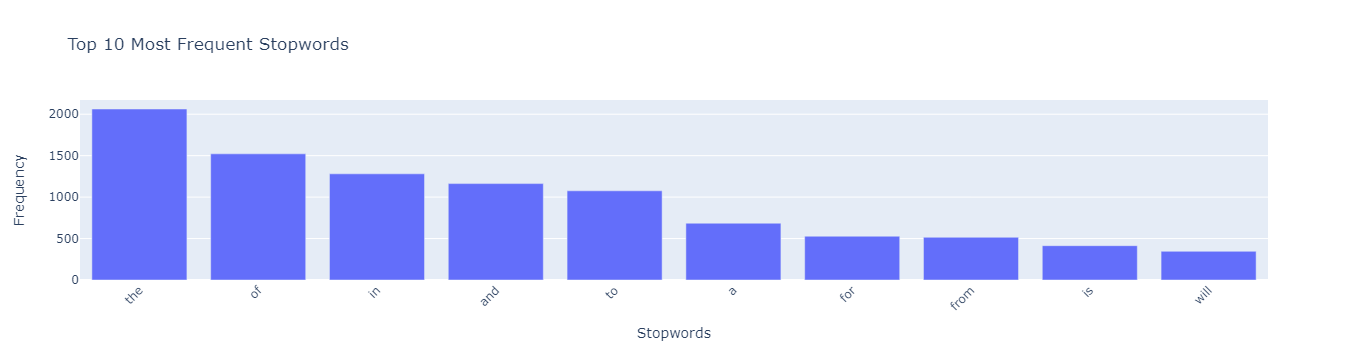

In [116]:
#plot to visualize most used stop words in the news
nltk.download('stopwords')
stop = set(stopwords.words('english'))
corpus = []
new = df_all['text'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

top_stopwords = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
x, y = zip(*top_stopwords)

fig = px.bar(x=x, y=y, labels={'x': 'Stopwords', 'y': 'Frequency'}, title='Top 10 Most Frequent Stopwords')
fig.update_layout(xaxis_tickangle=-45, width=800)
fig.show()


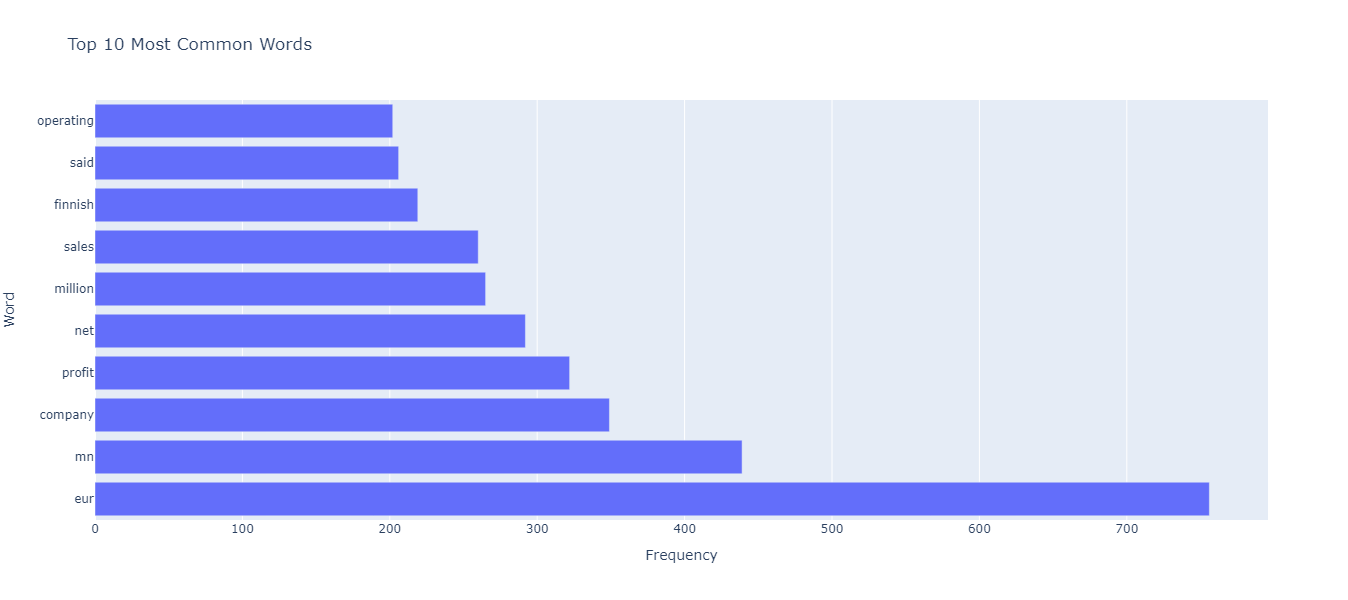

In [117]:
#The plot above showed the frequently used stop words. Following plot shows frequently used non-stop words
counter = Counter()
for word in corpus:
    # Removing special characters and stop words
    word = re.sub(r'[^a-zA-Z0-9\s]', '', word)
    if word.lower() not in stop and word != '':
        counter[word.lower()] += 1

most_common = counter.most_common()

x, y = zip(*most_common[:10])

fig = px.bar(x=y, y=x, orientation='h', 
             labels={'x': 'Frequency', 'y': 'Word'},
             title='Top 10 Most Common Words')
fig.update_layout(height=600, width=800)
fig.show()


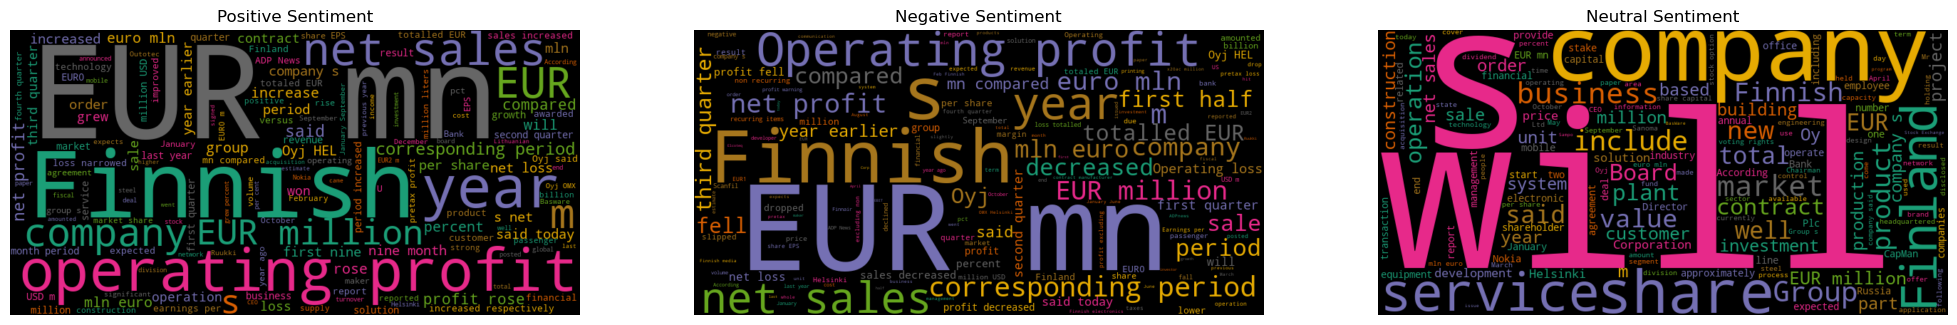

In [118]:
#Created words for each sentiment.We can notice words like "net profit" , "increased" in the positive sentiment and words like "net loss" and "decreased" in negative sentiment. 
#The word "Finnish" appear in all sentiments which makes me think most of these news are from Finland
positive_news = ' '.join(df_all[df_all['sentiment'] == 'positive']['text'])
negative_news = ' '.join(df_all[df_all['sentiment'] == 'negative']['text'])
neutral_news = ' '.join(df_all[df_all['sentiment'] == 'neutral']['text'])

#WordCloud for each sentiment
wordcloud_positive = WordCloud(width=800, height=400, max_words=150,colormap="Dark2").generate(positive_news)
wordcloud_negative = WordCloud(width=800, height=400, max_words=150,colormap="Dark2").generate(negative_news)
wordcloud_neutral = WordCloud(width=800, height=400, max_words=150,colormap="Dark2").generate(neutral_news)


plt.figure(figsize=(25, 15))

plt.subplot(131)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Sentiment')
plt.axis('off')

plt.subplot(132)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Sentiment')
plt.axis('off')

plt.subplot(133)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Sentiment')
plt.axis('off')

plt.show()

In [122]:
X = df_all.drop('sentiment', axis = 1)
y = df_all['sentiment']

In [123]:
X

,text
0,"According to Gran , the company has no plans t..."
1,"For the last quarter of 2010 , Componenta 's n..."
2,"In the third quarter of 2010 , net sales incre..."
3,Operating profit rose to EUR 13.1 mn from EUR ...
4,"Operating profit totalled EUR 21.1 mn , up fro..."
...,...
2259,Operating result for the 12-month period decre...
2260,HELSINKI Thomson Financial - Shares in Cargote...
2261,LONDON MarketWatch -- Share prices ended lower...
2262,Operating profit fell to EUR 35.4 mn from EUR ...


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X['text'], y, random_state = 42)

In [30]:
X_train.head()

705     The prerequisite for inclusion in the program ...
1146    A total 30 % of the order value was booked in ...
581     Panostaja , headquartered in Tampere , Finland...
429     Finnish consulting and engineering group Poyry...
891     The company is listed on the Nordic Exchange i...
Name: text, dtype: object

In [119]:
#Used stemmer to process the text to it root form
def stemmer(text):
    stem = PorterStemmer()
    return ' '.join([stem.stem(w) for w in word_tokenize(text)])

In [33]:
stemmed_content = df_all['text'].apply(stemmer)
print(type(stemmed_content))
print(stemmed_content.head())

<class 'pandas.core.series.Series'>
0    accord to gran , the compani ha no plan to mov...
1    for the last quarter of 2010 , componenta 's n...
2    in the third quarter of 2010 , net sale increa...
3    oper profit rose to eur 13.1 mn from eur 8.7 m...
4    oper profit total eur 21.1 mn , up from eur 18...
Name: text, dtype: object


In [124]:
#Used lemmatization which stems the words based on context
def lemmatizer(text):
    lemma = WordNetLemmatizer()
    return ' '.join([lemma.lemmatize(w) for w in word_tokenize(text)])

In [125]:
lemmatized_content = df_all['text'].apply(lemmatizer)

print(type(lemmatized_content))
print(lemmatized_content.head())

<class 'pandas.core.series.Series'>
0    According to Gran , the company ha no plan to ...
1    For the last quarter of 2010 , Componenta 's n...
2    In the third quarter of 2010 , net sale increa...
3    Operating profit rose to EUR 13.1 mn from EUR ...
4    Operating profit totalled EUR 21.1 mn , up fro...
Name: text, dtype: object


In [126]:
lemmatized_content.head()

0    According to Gran , the company ha no plan to ...
1    For the last quarter of 2010 , Componenta 's n...
2    In the third quarter of 2010 , net sale increa...
3    Operating profit rose to EUR 13.1 mn from EUR ...
4    Operating profit totalled EUR 21.1 mn , up fro...
Name: text, dtype: object

In [127]:
#Decided to use the lemmatized content to build the model since we are dealing with financial news
X_train, X_test, y_train, y_test = train_test_split(lemmatized_content, y, random_state = 42)

In [128]:
X_train

705     The prerequisite for inclusion in the program ...
1146    A total 30 % of the order value wa booked in t...
581     Panostaja , headquartered in Tampere , Finland...
429     Finnish consulting and engineering group Poyry...
891     The company is listed on the Nordic Exchange i...
                              ...                        
1638    For 2009 , net profit wa EUR3m and the company...
1095      The new SEPA cad will replace Finnish bank card
1130    ` Nordic infrastructure construction is one of...
1294    Market data and analytics are derived from pri...
860     Cargotec Corporation , Press Release , August ...
Name: text, Length: 1698, dtype: object

In [129]:
y_train

705      neutral
1146     neutral
581      neutral
429     positive
891      neutral
          ...   
1638     neutral
1095     neutral
1130     neutral
1294     neutral
860     positive
Name: sentiment, Length: 1698, dtype: object

In [134]:
#using count vectorizer to convert the text date into a sparse matrix
cvect = CountVectorizer(stop_words = 'english', max_features = 300)
X_train_vect = cvect.fit_transform(X_train)
X_test_vect = cvect.transform(X_test)

In [132]:
X_train_vect

<1698x300 sparse matrix of type '<class 'numpy.int64'>'
	with 10176 stored elements in Compressed Sparse Row format>

In [135]:
#pipeline to build a logistic regression model
lgr_count = Pipeline([('cvect', CountVectorizer(stop_words = 'english')),
                       ('lgr', LogisticRegression(max_iter=1000))])
lgr_count.fit(X_train, y_train)
lgr_count_acc = lgr_count.score(X_test, y_test)

In [41]:
params = {'cvect__max_features': [100, 500, 1000, 2000],
         'cvect__stop_words': ['english', None]}

In [42]:
import time
start_time = time.time()
lgr_count_grid = GridSearchCV(lgr_count, param_grid=params)
lgr_count_grid.fit(X_train, y_train)
end_time = time.time()
time_lgr_count = (end_time - start_time)
lgr_count_grid_acc = lgr_count_grid.score(X_test, y_test)
lgr_count_param = lgr_count_grid.best_params_['cvect__max_features']

In [136]:
#time taken to fit the model
time_lgr_count

12.965894937515259

In [137]:
#Accuracy of the model
lgr_count_grid_acc

0.8833922261484098

In [138]:
#Best max features
lgr_count_param

2000

In [147]:
#Build a logistic regression model using Tfid Vectorizer instead of Count Vectorized and compared the results
lgr_tfidf = Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english')),
                       ('lgr', LogisticRegression(max_iter=1000))])
lgr_tfidf.fit(X_train, y_train)
lgr_tfidf_acc = lgr_tfidf.score(X_test, y_test)

In [140]:
params = {'tfidf__max_features': [100, 500, 1000, 2000],
         'tfidf__stop_words': ['english', None]}

In [141]:
start_time = time.time()
lgr_tfidf_grid = GridSearchCV(lgr_tfidf, param_grid=params)
lgr_tfidf_grid.fit(X_train, y_train)
end_time = time.time()
time_lgr_tfidf = (end_time - start_time)
lgr_tfidf_grid_acc = lgr_tfidf_grid.score(X_test, y_test)
lgr_tfidf_param = lgr_tfidf_grid.best_params_['tfidf__max_features']

In [142]:
time_lgr_tfidf

11.920262575149536

In [143]:
lgr_tfidf_grid_acc

0.8568904593639576

In [144]:
lgr_tfidf_param

500

In [145]:
res_dict = {'model': ['LR-Lemmatized-Count', 'LR-Lemmatized-TFID'],
           'best_params': [lgr_count_param, lgr_tfidf_param],
           'best_score': [lgr_count_grid_acc, lgr_tfidf_grid_acc],
           'fit time': [time_lgr_count, time_lgr_tfidf]}
results_df = pd.DataFrame(res_dict).set_index('model')

In [146]:
results_df

,best_params,best_score,fit time
model,,,
LR-Lemmatized-Count,2000,0.883392,12.965895
LR-Lemmatized-TFID,500,0.856890,11.920263


#### The Logistic regression model with Count Ventorizer has better accuracy than Tfid Vectorizer. I expected the model with Tfid Vectorizer to perform better because it focuses on the importance of words in the text. So there is scope to tune this model. Will expore it in part 2 of the capstone.